# Find-It UGM 2023 - DAGO SCIENTIST

Anggota:

1. Albert Hosea
2. Kevin Sean Hans Lopulalan
3. Nanda Pramudia Santosa

# Goals

Untuk mengantisipasi seberapa besar kemungkinan orang terkena H1N1 dan menerima vaksin flu tahunan mereka. Hal ini dilakukan dengan memprediksi dua kemungkinan: satu untuk vaksin_H1N1 dan satu lagi untuk vaksin_seasonal. Setiap baris dalam kumpulan data mewakili satu individu dari Survei Flu Nasional H1N1 (NHFS) tahun 2009 oleh CDC

# Setup

## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pf
%matplotlib inline
from pingouin import multivariate_normality

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3524/2143255049.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pf


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
import optuna

## Load data

In [3]:
train = pd.read_csv('dataset/training_set_features.csv', index_col='respondent_id')
test = pd.read_csv('dataset/test_set_features.csv', index_col='respondent_id')
labels = pd.read_csv('dataset/training_set_labels.csv', index_col='respondent_id')

# Exploratory Data Analysis (EDA)

## Data Description

Flu babi, sering dikenal sebagai flu babi, disebabkan oleh jenis virus flu (influenza) yang dikenal sebagai H1N1. Ini adalah virus influenza tipe A, dan H1N1 adalah salah satu dari banyak virus flu yang dapat menyebabkan flu musiman. Gejala flu H1N1 mirip dengan gejala flu musiman. Pada musim semi 2009, para ilmuwan mengidentifikasi satu strain dari virus flu H1N1. Virus ini adalah gabungan dari virus yang menyebabkan penyakit pada orang dari babi, burung, dan manusia. H1N1 menyebabkan infeksi saluran pernapasan pada manusia yang dikenal sebagai flu babi selama musim flu 2009-2010. Karena begitu banyak orang yang sakit, Organisasi Kesehatan Dunia (WHO) menyatakan virus H1N1 sebagai pandemi pada tahun 2009. WHO menyatakan wabah itu berakhir pada Agustus 2010. Setelah berakhirnya pandemi, virus flu H1N1 menjadi salah satu dari beberapa jenis yang menyebabkan flu musiman.

Untungnya, vaksin flu sekarang tersedia yang dapat membantu melindungi terhadap flu H1N1 (flu babi). Vaksin flu musiman, termasuk yang diproduksi pada tahun 2020 dan 2021, termasuk virus flu H1N1. Pandemi COVID-19 melanda dunia pada tahun 2019. Menyusul hasil beberapa penelitian tentang H1N1 dan SARS, para ahli menyimpulkan bahwa COVID-19 juga dikategorikan sebagai penyakit flu musiman. Penyakit ini juga menghambat upaya untuk membuat vaksin untuk melawan flu musiman.Berikut adalah deskripsi dari tiap feature yang ada di dataset seperti yang dijelaskan pada kolom Dataset Description pada halaman kaggle lomba. 

For all binary variables: 0 = No; 1 = Yes.

- h1n1_concern - Level of concern about the H1N1 flu.
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
- h1n1_knowledge - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
- behavioral_antiviral_meds - Has taken antiviral medications. (binary)
- behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
- behavioral_face_mask - Has bought a face mask. (binary)
- behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
- behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
- behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
- behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
- doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
- doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
- chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
- child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
- health_worker - Is a healthcare worker. (binary)
- health_insurance - Has health insurance. (binary)
- opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- age_group - Age group of respondent.
- education - Self-reported education level.
- race - Race of respondent.
- sex - Sex of respondent.
- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
- marital_status - Marital status of respondent.
- rent_or_own - Housing situation of respondent.
- employment_status - Employment status of respondent.
- hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
- census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
- household_adults - Number of other adults in household, top-coded to 3.
- household_children - Number of children in household, top-coded to 3.
- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

In [ ]:
train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [ ]:
train.describe(include='all')

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,22284,25299,24665,25244,26707,26707,26458.000000,26458.000000,13377,13237
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,2,3,10,3,NaN,NaN,21,23
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",NaN,NaN,fcxhlnwr,xtkaffoo
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12777,13555,18736,13560,4297,11645,NaN,NaN,2468,1778
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,NaN,NaN,NaN,NaN,NaN,NaN,0.886499,0.534583,NaN,NaN
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,NaN,NaN,NaN,NaN,NaN,NaN,0.753422,0.928173,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN


In [ ]:
train.isnull().any()

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
health_insurance                True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                       True
race                           False
sex                            False
income_poverty                  True
marital_status                  True
r

Dapat kita lihat bahwa dataset yang kita miliki memiliki beberapa nilai null, sehingga Data Cleansing dan Data Preparation lebih lanjut diperlukan.

## Data Pre-processing

Melakukan pembagian kolom berdasarkan tipe data yaitu numerik, kategorik, dan ordinal.

In [4]:
"""Pembagian Kolom Berdasarkan Tipe"""

num_cols = train.select_dtypes('number').columns

cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

### Data Imputation

Melakukan data imputation. Strategi data imputation yang kami lakukan adalah mengisi nilai yang kosong dengan 'None' untuk data dengan tipe data object (kategorikal dan ordinal) serta dengan nilai -1 untuk tipe data numerik.

#### Train Data Imputation

In [5]:
# data imputation untuk tipe data kategorikal dan ordinal
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [6]:
# data imputation untuk tipe data numerik
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

#### Test Data Imputation

In [ ]:
# Categorical columns None
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

In [ ]:
#data imputation untuk tipe data numerik
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

## General Analysis

Kita akan melihat distribusi dari variabel target kita (h1n1_vaccine dan seasonal_vaccine)

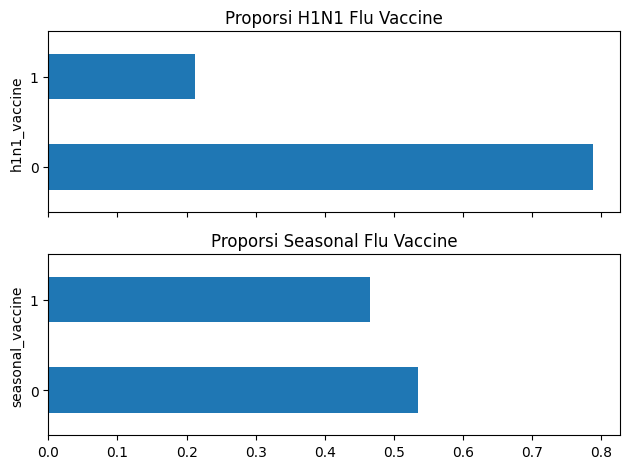

In [ ]:
"""Proporsi H1N1 Flu Vaccine dan Proporsi Seasonal Flu Vaccine"""

fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels.shape[0]

# plot proporsi data h1n1_vaccine
(labels['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proporsi H1N1 Flu Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

# plot proporsi data seasonal_vaccine
(labels['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proporsi Seasonal Flu Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

Dari data yang diperoleh, sekitar setengah dari populasi menerima vaksin flu musiman, sedangkan hanya sekitar 20% dari populasi yang menerima vaksin flu H1N1. Dalam konteks keseimbangan kelas, dapat disimpulkan bahwa target vaksin flu seasonal memiliki kelas yang seimbang, namun target vaksin flu H1N1 memiliki kelas yang cukup tidak seimbang.

In [ ]:
pd.crosstab(
    labels["h1n1_vaccine"], 
    labels["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [ ]:
labels["h1n1_vaccine"].corr(labels["seasonal_vaccine"], method="pearson")

0.37714265306144495

Pandang bahwa koefisien korelasi phi sebesar 0.377 menandakan adanya korelasi positif antara h1n1_vaccine dan seasonal_vaccine. Dari tabulasi yang dibuat juga diperoleh bahwa orang yang mendapatkan vaksin flu musiman cenderung lebih mungkin juga mendapatkan vaksin flu H1N1, namun tidak semua orang yang mendapatkan vaksin flu H1N1 juga mendapatkan vaksin flu musiman.

## Multivariate Analysis

Kita mulai dengan analisis kenormalan multivariat data.

In [ ]:
"""Multivariate Normality Test untuk variabel numerik"""
multivariate_normality(train[[n for n in num_cols]], alpha=.05)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

Karena p-value<alpha, maka H0 (data multivariat normal) ditolak sehingga variabel-variabel tidak multivariat normal. Hasil tersebut menunjukan secara keseluruhan,variabel-variabel satu sama lain tidak memiliki korelasi yang kuat. Hal ini didukung dengan matriks kovariansi di bawah ini.

In [10]:
# membuat dataframe gabungan antara features dengan label
joined = train.join(labels)

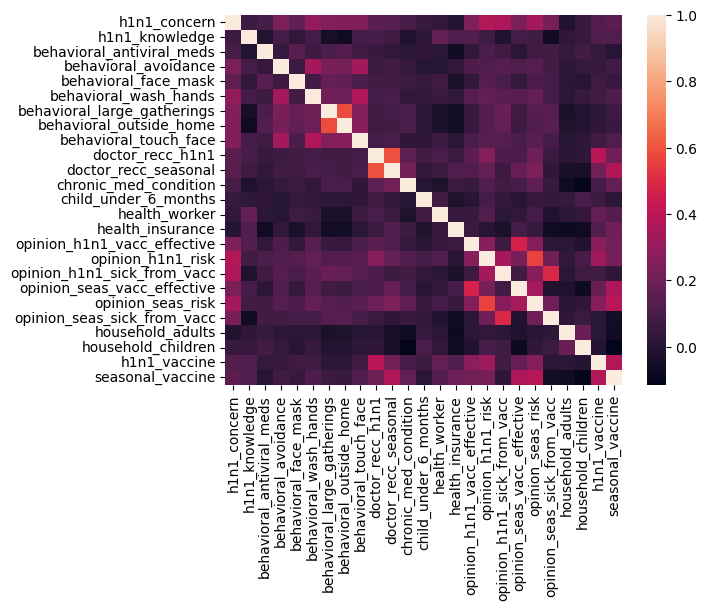

In [ ]:
"""Matriks Kovariansi"""
corr_matrix = joined.corr()
sns.heatmap(corr_matrix, annot=False)
plt.show()

Di atas adalah matriks kovariansi yang menjelaskan bagaimana hubungan antara tiap-tiap variabel. Dari plot kita peroleh bahwa sebagian besar variabel memiliki hubungan kovariansi mendekati nol (warna gelap), hanya sebagian kecil saja yang memiliki nilai kovariansi lebih besar (warna terang). Kebanyakan variabel yang berpengaruh adalah mereka yang mempunyai frasa kata pertama yang sama (behavioral, doctor, opinion, etc). Kita bisa melihat bahwa minimnya variabel-variabel yang mempunyai matriks kovariansi negatif yang artinya, lebih banyak data yang tidak saling berhubungan daripada yang saling berbanding terbalik.

Kemudian, perhatikan bahwa variabel yang berpengaruh terhadap variabel keputusan h1n1_vaccine punya hubungan sebanding yang lebih besar terhadap variabel-variabel doctor_recc_h1n1, opinion_h1n1_risk, opinion_h1n1_vacc_effective. Hal serupa terjadi pada variabel keputusan seasonal_vaccine yang juga punya hubungan sebanding yang lebih besar terhadap variabel-variabel doctor_recc_seasonal, opinion_seas_vacc_effective, opinion_seas_risk. Hal ini sesuai dengan jurnal Increasing Vaccination: Putting Psychological Science Into Action (Brewer et al., 2017) dan The influence of political ideology and trust on willingness to vaccinate (Baumgaertner et al., 2018) bahwa memang terdapat hubungan antara rekomendasi doktor, opini terhadap resiko dan efektifitas vaksin terhadap kehendak orang ikut vaksinasi sehingga proporsi variabel-variabel ini dalam menentukan variabel keputusan lebih tinggi dari pada variabel-variabel lainnya.

In [7]:
"""Fungsi Plot Perbandingan Feature terhadap Variabel Target"""

# Fungsi ploting stacker bar antara features dan label
def vac_plot(col, target, data, ax=None):
    counts = (joined[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    properties = counts.div(group_counts, axis='index')

    properties.plot(kind="barh", stacked=True, ax=ax, color=['#FFDFDE', '#6A7BA2'])
    ax.invert_yaxis()
    ax.legend().remove()

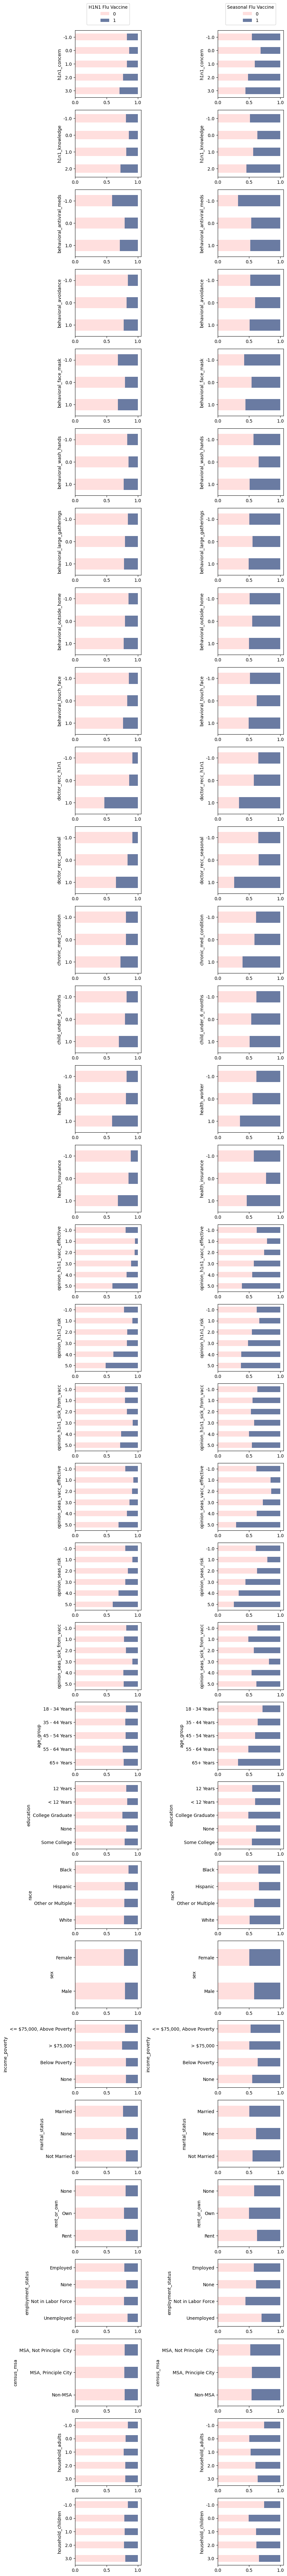

In [11]:
"""Plot Perbandingan Feature terhadap Variabel Target"""
# Kolom yang diplot
col_list = train.drop(['employment_occupation', 'employment_industry', 'hhs_geo_region'], axis=1).columns

# Setup plotting
fig, ax = plt.subplots(len(col_list), 2, figsize=(9,len(col_list)*2.5))

# Plot tiap kolom pada 'col_list'
for idx, col in enumerate(col_list):
    vac_plot(col, 'h1n1_vaccine', joined, ax=ax[idx, 0])
    vac_plot(col, 'seasonal_vaccine', joined, ax=ax[idx, 1])
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='H1N1 Flu Vaccine')
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Seasonal Flu Vaccine')
fig.tight_layout()


Dari hasil analisis, terlihat bahwa terdapat korelasi yang cukup kuat pada kedua variabel target yaitu knowledge dan opinion. Meskipun fitur demografis menunjukkan korelasi yang lebih kuat dengan vaksin flu musiman, korelasinya jauh lebih rendah pada vaksin flu H1N1. Ditemukan korelasi yang kuat antara kelompok usia dengan vaksin flu musiman, tetapi tidak terdapat korelasi yang signifikan dengan vaksin flu H1N1. Pada flu musiman, terlihat bahwa perilaku masyarakat sesuai dengan fakta bahwa orang yang lebih tua lebih terpengaruh dan memiliki risiko lebih tinggi terhadap komplikasi terkait flu. Namun, pada flu H1N1, terungkap bahwa usia memiliki hubungan yang menarik: meskipun orang yang lebih tua memiliki risiko lebih tinggi terhadap komplikasi, mereka lebih sedikit kemungkinan terinfeksi. Meskipun sebab dan akibat dari temuan ini belum diketahui, faktor risk tercermin dalam tingkat vaksinasi. 

Kita sudah melihat analsis multivariat, dan hasil menunjukan bahwa rendahnya korelasi hampir tiap antar variabel. Sekarang akan ditunjukan bagaimana tiap properti setiap variabel.

## Univariate Analysis

Kita akan melihat bagaimana properti seluruh data secara simultan.

/tmp/ipykernel_1060/1193584864.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[column], ax=ax, label=column)
/tmp/ipykernel_1060/1193584864.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[column], ax=ax, label=column)
/tmp/ipykernel_1060/1193584864.py:6: UserWarning: 

`distp

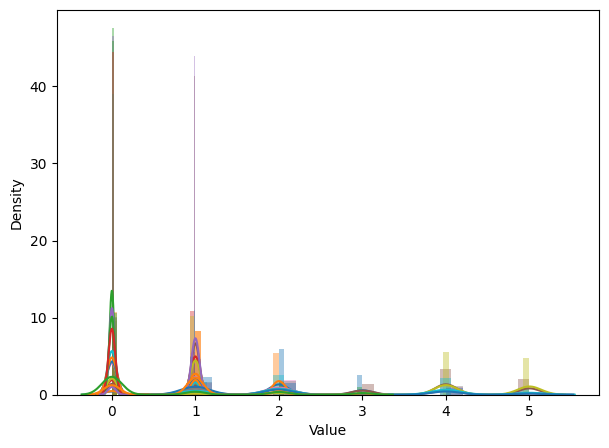

In [ ]:
"""Analisis Seluruh Data Secara Simultan"""

# buat layout dan sumbu plot
fig, ax = plt.subplots(figsize=(7, 5))

# plot setiap kolom data numerik di num_cols
for column in num_cols:
    sns.distplot(train[column], ax=ax, label=column)

# atur setting plot
ax.set_xlabel('Value')
ax.set_ylabel('Density')
plt.show()


Lalu kita tinjau masing-masing distribusi variabelnya.

/tmp/ipykernel_1060/3450192355.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[column], ax=ax[i//5, i%5], label=column)
/tmp/ipykernel_1060/3450192355.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[column], ax=ax[i//5, i%5], label=column)
/tmp/ipykernel_1060/3450192355.py:6:

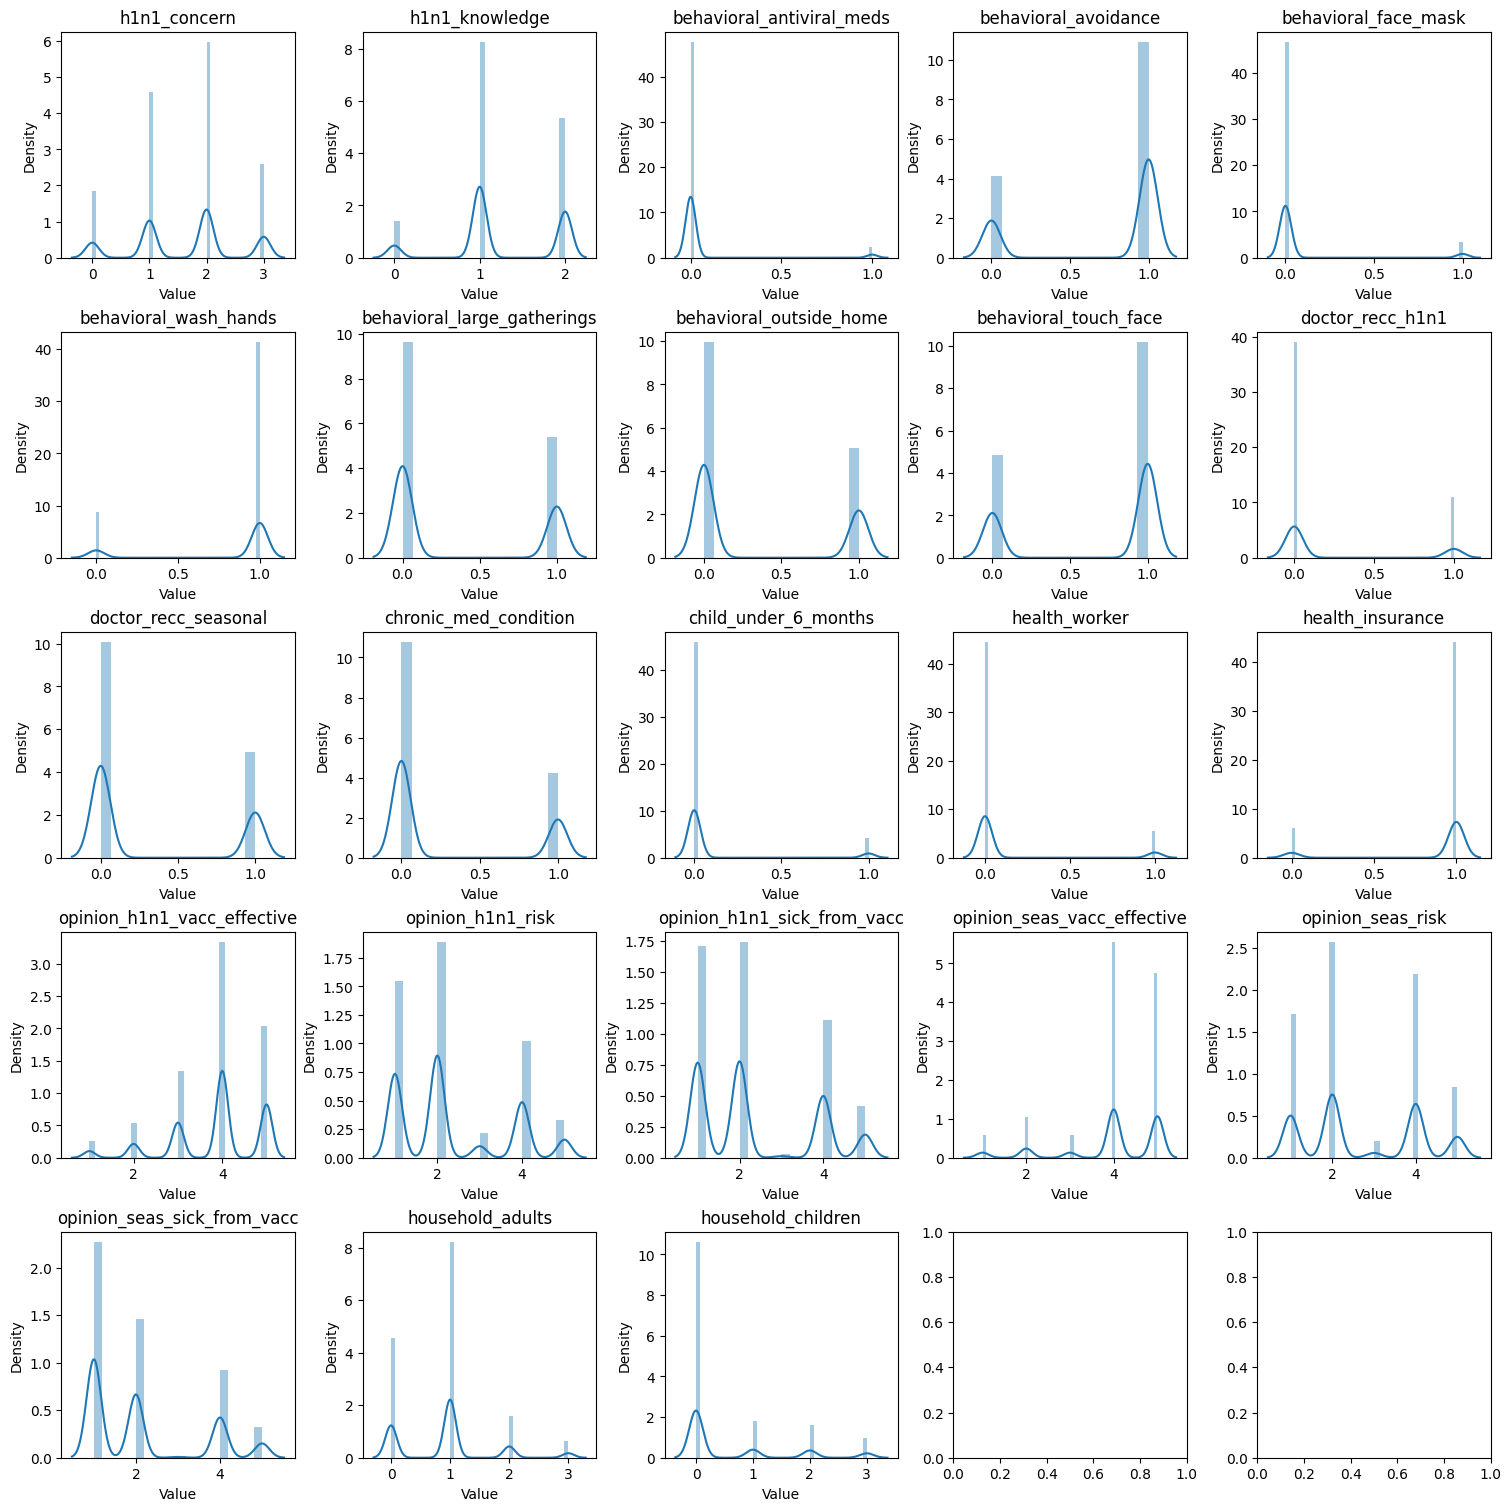

In [ ]:
"""Analisis Seluruh Data per Kolom"""

# Pembuatan sumbu dan layout
fig, ax = plt.subplots(5, 5, figsize=(15,15), constrained_layout=True)

# Melakukan plotting  
for i, column in enumerate(num_cols):
    sns.distplot(train[column], ax=ax[i//5, i%5], label=column)
    ax[i//5, i%5].set_xlabel('Value')
    ax[i//5, i%5].set_ylabel('Density')
    ax[i//5, i%5].set_title(column)

plt.show()


Dari hasil plotting diperoleh bahwa plot yang mengikuti Benford's Law mengindikasikan bahwa distribusi digit pertama (leading digit) dari kumpulan data tersebut mengikuti pola yang diharapkan menurut hukum Benford dan menunjukkan bahwa data tersebut memiliki karakteristik yang konsisten dengan hukum Benford, dan dapat digunakan untuk memverifikasi integritas data atau untuk mendeteksi adanya anomali atau ketidakberesan dalam data tersebut. Sementara plot yang tidak mengikuti Benford's Law bisa dikarenakan oleh kurangnya data dalam pengolahan. Dapat dipandang juga bahwa data yang diperoleh memiliki skala yang kurang lebih sama sehingga data memenuhi salah satu syarat untuk membuat model machine learning robust.

# Modeling

Pada pemodelan kami menggunakan CatBoost. CatBoost sendiri dikenal bekerja baik untuk data-data yang bersifat kategorikal sehingga sangat cocok digunakan untuk dataset yang kita gunakan disini dimana feature feature yang ada banyak merupakan tipe data kategorikal (termasuk ordinal). 

CatBoost mampu mengatasi variabel kategorikal dengan efektif tanpa memerlukan proses Feature Engineering. Algoritma ini dapat secara otomatis mengonversi variabel kategorikal menjadi nilai numerik dan mengenkodenasinya menggunakan beberapa metode seperti one-hot encoding, target encoding, dan ordered target encoding.

Lalu untuk mencari Hyperparameter terbaik, metode hyperparameter tuning yang kami gunakan adalah menggunakan Optuna.

## Train test split

In [ ]:
"""Train Test Split"""
from sklearn.model_selection import train_test_split

In [ ]:
# membagi dataset menjadi train dan test untuk keperluan validasi
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

In [ ]:
# index feature kategorikal (non-numerik)
categorical_features_indices = np.where(X_train.dtypes != float)[0]

## H1N1 Flu Vaccine

### Optuna Hyperparameter Tuning

In [ ]:
train_dataset = Pool(data=X_train,
                     label=y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [ ]:
"""Study Function"""

# Setup study function Optuna yang akan digunakan saat proses Hyperparameter Tuning berjalan.
def objective(trial):
    # parameter dari CatBoost
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

Untuk sampler kami menggunakan TPE (Tree-structured Parzen Estimator) . Pendekatan ini bergantung pada probabilitas Bayesian untuk menentukan pemilihan hyperparameter yang paling menjanjikan dan secara iteratif menyesuaikan pencarian.

In [ ]:
"""Memulai Hyperparameter Tuning"""

# sampler
sampler = optuna.samplers.TPESampler(seed=68)

# memulai proses pencarian hyperparameter terbaik
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2023-05-11 05:36:51,306] A new study created in memory with name: no-name-31510a5f-6e74-4710-938c-9711374c8e53
/tmp/ipykernel_204/256797340.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
Training on fold [0/5]

bestTest = 0.4280156142
bestIteration = 575

Training on fold [1/5]

bestTest = 0.4213185489
bestIteration = 547

Training on fold [2/5]

bestTest = 0.4323831903
bestIteration = 510

Training on fold [3/5]

bestTest = 0.4292278045
bestIteration = 463

Training on fold [4/5]
[I 2023-05-11 05:37:04,514] Trial 0 finished with value: 0.8634470494751192 and parameters: {'iterations': 1500, 'learning_rate': 0.029356482739949695, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf

KeyboardInterrupt: 

Mencetak Hyperparameter terbaik CatBoost untuk dataset yang kita miliki

In [ ]:
"""Hyperparameter Terbaik untuk Prediksi H1N1 Vaccine"""

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")

# iterasi terbaik
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")

# mem-print parameter terbaik
for key, value in trial.params.items():
    print("    {}={},".format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.8679538793376752
  Params: 
    iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy=Lossguide,
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights=Balanced,


### Final Model (H1N1 Flu Vaccine)

In [ ]:
# model CatBoost dengan Hyperparameter optimal yang sudah dicari sebelumnya
final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                          **trial.params)

In [ ]:
# train model
final_model.fit(X_train, y_train.h1n1_vaccine)

In [ ]:
# validasi
predictions_h1 = final_model.predict_proba(X_test)
predictions_h1 = predictions_h1[:,1].reshape(-1,1)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# fungsi plot ROC (TPR terhadap FPR)
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

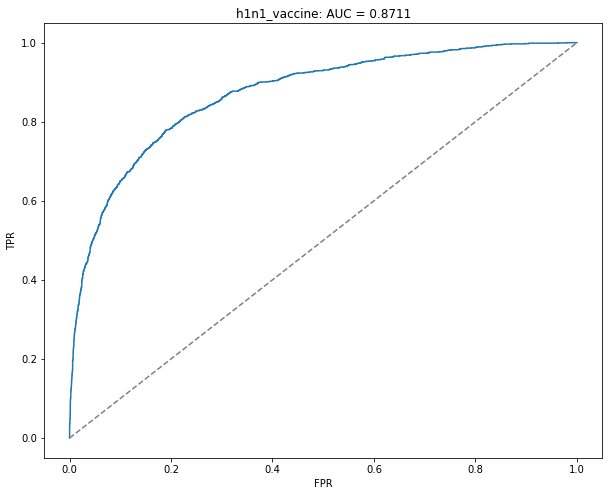

In [ ]:
"""ROC AUC Plot"""

# memunculkan plot ROC ke layar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'], 
    predictions_h1, 
    'h1n1_vaccine',
    ax=ax
)

In [ ]:
# score ROC AUC untuk prediksi model H1N1 Flu Vaccine
roc_auc_score(y_test.h1n1_vaccine, predictions_h1)

0.8710964730481472

## Seasonal Flu Vaccine

### Optuna Hyperparameter Tuning

In [ ]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [ ]:
"""Study Function"""

# Setup study function Optuna yang akan digunakan saat proses Hyperparameter Tuning berjalan.
def objective2(trial):
    # parameter dari CatBoost
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [ ]:
"""Memulai Hyperparameter Tuning"""

# sampler
sampler = optuna.samplers.TPESampler(seed=68)

# memulai proses pencarian hyperparameter terbaik
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

[I 2021-02-17 01:58:46,608] A new study created in memory with name: no-name-03913ebf-5557-4268-9f2c-43f40117f5aa
[I 2021-02-17 01:59:12,754] Trial 0 finished with value: 0.8592774453063841 and parameters: {'iterations': 300, 'learning_rate': 0.013964954297408176, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 21.328495943450676, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8592774453063841.
[I 2021-02-17 01:59:26,032] Trial 1 finished with value: 0.8599969087296045 and parameters: {'iterations': 1200, 'learning_rate': 0.11477165079768124, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 0.5714362138520529, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8599969087296045.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:01,309] Trial 2 finished with value: 0.861608374321975 and parameters: {'iterations': 1500, 'learning_rate': 0.06018181691194878, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.937278880272323e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:14,015] Trial 3 finished with value: 0.8586019282142363 and parameters: {'iterations': 100, 'learning_rate': 0.04917655399574397, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 1.253388039132331e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.
[I 2021-02-17 02:00:27,447] Trial 4 finished with value: 0.8602753191026151 and parameters: {'iterations': 1500, 'learning_rate': 0.20567786125414012, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 2, 'l2_leaf_reg': 0.0011659140576640084, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:00:34,719] Trial 5 finished with value: 0.8567640003480698 and parameters: {'iterations': 100, 'learning_rate': 0.21103536986772822, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 1.5248267732768012e-08, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.861608374321975.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:10,069] Trial 6 finished with value: 0.8617699180315392 and parameters: {'iterations': 1000, 'learning_rate': 0.039222305770230614, 'random_strength': 5, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 4, 'l2_leaf_reg': 3.544948380552023e-06, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:44,172] Trial 7 finished with value: 0.860718479761989 and parameters: {'iterations': 1000, 'learning_rate': 0.045869610193466345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 6.629274905463984e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:48,686] Trial 8 finished with value: 0.8518659419954195 and parameters: {'iterations': 1500, 'learning_rate': 0.2775338323862574, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 0.0010943835695463693, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:01:52,676] Trial 9 finished with value: 0.8576354127969263 and parameters: {'iterations': 1000, 'learning_rate': 0.16527427195333977, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 5.547808519611033e-05, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:11,155] Trial 10 finished with value: 0.8616278814855303 and parameters: {'iterations': 500, 'learning_rate': 0.11039932312091873, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 1.2159249519874814e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:30,680] Trial 11 finished with value: 0.8613644301746106 and parameters: {'iterations': 500, 'learning_rate': 0.1084207966325659, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 1.2894289326228455e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:02:55,635] Trial 12 finished with value: 0.8357434471221705 and parameters: {'iterations': 500, 'learning_rate': 0.004806416713353634, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 2, 'l2_leaf_reg': 6.39944753546505e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.
[I 2021-02-17 02:03:11,141] Trial 13 finished with value: 0.8616457635070617 and parameters: {'iterations': 1000, 'learning_rate': 0.10411608463872443, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 1.276003870120915e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8617699180315392.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:03:38,197] Trial 14 finished with value: 0.8619148959330752 and parameters: {'iterations': 1000, 'learning_rate': 0.07618156061546405, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 3.5865647557736247e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:03:50,054] Trial 15 finished with value: 0.8549497979408294 and parameters: {'iterations': 1000, 'learning_rate': 0.06969554503907559, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 0.0002906071529974482, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:04:00,196] Trial 16 finished with value: 0.8609895930428383 and parameters: {'iterations': 200, 'learning_rate': 0.15325494851429844, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 6.938536064744217e-07, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:05:03,898] Trial 17 finished with value: 0.8564992332206849 and parameters: {'iterations': 1000, 'learning_rate': 0.009317706201861467, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 4, 'l2_leaf_reg': 0.04373352118950405, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.
[I 2021-02-17 02:05:09,478] Trial 18 finished with value: 0.8367012309165419 and parameters: {'iterations': 1000, 'learning_rate': 0.07767821367355207, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 10, 'l2_leaf_reg': 2.5602616797376855e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:05:26,289] Trial 19 finished with value: 0.8498049035164978 and parameters: {'iterations': 300, 'learning_rate': 0.017984347045110226, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 3, 'l2_leaf_reg': 1.2398896982274805e-06, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 14 with value: 0.8619148959330752.
[I 2021-02-17 02:06:08,776] Trial 20 finished with value: 0.8619727265448246 and parameters: {'iterations': 1200, 'learning_rate': 0.03236712628327796, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 0.046219859585272895, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:06:47,953] Trial 21 finished with value: 0.8597350906668979 and parameters: {'iterations': 1200, 'learning_rate': 0.03452823865248107, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 7, 'l2_leaf_reg': 0.018537719843351754, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:07:08,229] Trial 22 finished with value: 0.8583524447935437 and parameters: {'iterations': 1200, 'learning_rate': 0.08575309147911239, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 0.3397573285506683, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 20 with value: 0.8619727265448246.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:08:17,337] Trial 23 finished with value: 0.8624260361198551 and parameters: {'iterations': 1200, 'learning_rate': 0.027247202810574488, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 39.55970394954269, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:08:31,360] Trial 24 finished with value: 0.8609916595255 and parameters: {'iterations': 1200, 'learning_rate': 0.13650969502800792, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 14.889821880428762, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:10:14,239] Trial 25 finished with value: 0.861997483772733 and parameters: {'iterations': 1200, 'learning_rate': 0.02712686924609191, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 88.84655832391311, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:11:59,242] Trial 26 finished with value: 0.8622215414530657 and parameters: {'iterations': 1200, 'learning_rate': 0.027279570694869436, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 95.65012826306524, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:12:09,964] Trial 27 finished with value: 0.8582590962360153 and parameters: {'iterations': 1200, 'learning_rate': 0.29935905333625645, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 9, 'l2_leaf_reg': 88.42202477486413, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:14:34,841] Trial 28 finished with value: 0.8448933869047659 and parameters: {'iterations': 1200, 'learning_rate': 0.0012883179018759842, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 4.507225065456655, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.
[I 2021-02-17 02:15:00,735] Trial 29 finished with value: 0.8511466699775211 and parameters: {'iterations': 200, 'learning_rate': 0.018121978525421818, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 82.80146360137286, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 23 with value: 0.8624260361198551.
[I 2021-02-17 02:16:10,806] Trial 30 finished with value: 0.8606369200848867 and parameters: {'iterations': 1200, 'learning_rate': 0.0253437097159

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:16:51,352] Trial 31 finished with value: 0.8624760408843091 and parameters: {'iterations': 1200, 'learning_rate': 0.05571026924312778, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 92.84631319598631, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:18:56,698] Trial 32 finished with value: 0.8422039202853909 and parameters: {'iterations': 1200, 'learning_rate': 0.0010313180718820245, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 24.67310566534338, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:19:31,048] Trial 33 finished with value: 0.859487821029903 and parameters: {'iterations': 1200, 'learning_rate': 0.062100494868209254, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 1.2952184669897353, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:20:06,984] Trial 34 finished with value: 0.8617578410670788 and parameters: {'iterations': 300, 'learning_rate': 0.052470154488746826, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 45.787192748037945, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:20:19,957] Trial 35 finished with value: 0.8616715967736706 and parameters: {'iterations': 1200, 'learning_rate': 0.09350163378814949, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 8.394192250872125, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:20:57,820] Trial 36 finished with value: 0.8611326533509001 and parameters: {'iterations': 1200, 'learning_rate': 0.051467883369440526, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 1.2592120964345, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:21:04,326] Trial 37 finished with value: 0.8448587047236252 and parameters: {'iterations': 100, 'learning_rate': 0.02568221228798362, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 87.48517216184811, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8624760408843091.
[I 2021-02-17 02:21:20,064] Trial 38 finished with value: 0.853128473568199 and parameters: {'iterations': 1200, 'learning_rate': 0.12773638178556146, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 0.22026399083527087, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:21:29,547] Trial 39 finished with value: 0.860400768400553 and parameters: {'iterations': 1200, 'learning_rate': 0.18799555523262435, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 22.52332464723313, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:22:06,265] Trial 40 finished with value: 0.861516799464793 and parameters: {'iterations': 1500, 'learning_rate': 0.042578219791789336, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 2.087481458571183, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:22:50,192] Trial 41 finished with value: 0.8609410005750432 and parameters: {'iterations': 1200, 'learning_rate': 0.030632757759002652, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 0.010120344084021772, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:23:14,283] Trial 42 finished with value: 0.8610182421679324 and parameters: {'iterations': 1200, 'learning_rate': 0.06461226321948788, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 0.054234637196588546, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8624760408843091.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:24:20,167] Trial 43 finished with value: 0.8628189010522164 and parameters: {'iterations': 1200, 'learning_rate': 0.04020226312212685, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 90.13854739728647, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:24:28,825] Trial 44 finished with value: 0.8535210908812981 and parameters: {'iterations': 100, 'learning_rate': 0.04924979597860921, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 40.94570190854328, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:26:30,637] Trial 45 finished with value: 0.8592894008103542 and parameters: {'iterations': 1200, 'learning_rate': 0.009427441664574057, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 10.287509791866576, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:26:39,562] Trial 46 finished with value: 0.8602585888878375 and parameters: {'iterations': 1200, 'learning_rate': 0.2533464487929

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:27:05,906] Trial 47 finished with value: 0.8614314481756443 and parameters: {'iterations': 1500, 'learning_rate': 0.09233047273917006, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 95.2433470499676, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:27:42,278] Trial 48 finished with value: 0.8620117436511997 and parameters: {'iterations': 500, 'learning_rate': 0.05910864313515036, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 4.8256119684481265, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:28:13,440] Trial 49 finished with value: 0.8620452402442842 and parameters: {'iterations': 500, 'learning_rate': 0.056721079608529255, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 5.3512189414574705, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:28:50,569] Trial 50 finished with value: 0.8622923239683138 and parameters: {'iterations': 500, 'learning_rate': 0.04192853723185702, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.6513400670834688, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:29:09,173] Trial 51 finished with value: 0.8568569561359218 and parameters: {'iterations': 200, 'learning_rate': 0.04160025060921315, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.7555161140528094, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:29:37,594] Trial 52 finished with value: 0.8621902474273602 and parameters: {'iterations': 500, 'learning_rate': 0.07329192392784331, 'random_strength': 9, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 14.58670726905145, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:30:02,870] Trial 53 finished with value: 0.8624964492575723 and parameters: {'iterations': 500, 'learning_rate': 0.07253083471785571, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 22.98843930329072, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:30:43,400] Trial 54 finished with value: 0.8576171145804865 and parameters: {'iterations': 500, 'learning_rate': 0.017936089217252614, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 31.27361535509004, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:31:04,463] Trial 55 finished with value: 0.8623314647519738 and parameters: {'iterations': 500, 'learning_rate': 0.08222021943922227, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 2.5013696924716973, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:18,140] Trial 56 finished with value: 0.8610512242661583 and parameters: {'iterations': 500, 'learning_rate': 0.11412893766081442, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.15433506787685775, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:36,692] Trial 57 finished with value: 0.8613923673116105 and parameters: {'iterations': 500, 'learning_rate': 0.085141915740434, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 2.5141006580046037, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:31:52,378] Trial 58 finished with value: 0.8612630878227835 and parameters: {'iterations': 500, 'learning_rate': 0.09589713030939544, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 0.43878407336956, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:07,086] Trial 59 finished with value: 0.8615545933637773 and parameters: {'iterations': 500, 'learning_rate': 0.12723347031619192, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 15.782010297515773, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:24,763] Trial 60 finished with value: 0.8603807833688792 and parameters: {'iterations': 500, 'learning_rate': 0.06767390848361435, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 0.0038331250495747165, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:32:48,765] Trial 61 finished with value: 0.8593328958417565 and parameters: {'iterations': 300, 'learning_rate': 0.04002795336574851, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 34.160901732588805, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.
[I 2021-02-17 02:33:12,403] Trial 62 finished with value: 0.8612478466653123 and parameters: {'iterations': 500, 'learning_rate': 0.08298667194068889, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 8.990875597184502, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8628189010522164.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:33:58,208] Trial 63 finished with value: 0.8629142688449043 and parameters: {'iterations': 500, 'learning_rate': 0.03491751310099027, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 1.8211023402465396, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:34:31,979] Trial 64 finished with value: 0.8623054972865773 and parameters: {'iterations': 500, 'learning_rate': 0.04107559164106448, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.7995434990095341, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:34:54,473] Trial 65 finished with value: 0.8625410372679563 and parameters: {'iterations': 500, 'learning_rate': 0.07106096822317107, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 2.273919878847142, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:12,578] Trial 66 finished with value: 0.8619768911739152 and parameters: {'iterations': 500, 'learning_rate': 0.07435748178285664, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 3, 'l2_leaf_reg': 2.341213045555641, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:27,906] Trial 67 finished with value: 0.8613733031099311 and parameters: {'iterations': 500, 'learning_rate': 0.10061698498467272, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 0.10944962662679808, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:51,483] Trial 68 finished with value: 0.8613503283172014 and parameters: {'iterations': 500, 'learning_rate': 0.05331669990575415, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.00018285984431075052, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:35:59,589] Trial 69 finished with value: 0.8566885276248998 and parameters: {'iterations': 100, 'learning_rate': 0.0641831119378872, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 6.043144943879615, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:36:50,508] Trial 70 finished with value: 0.8604960386211935 and parameters: {'iterations': 500, 'learning_rate': 0.013594721532242872, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 1.77312277797755, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:37:41,634] Trial 71 finished with value: 0.862710225312353 and parameters: {'iterations': 500, 'learning_rate': 0.0350151166318715, 'random_

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:38:21,519] Trial 72 finished with value: 0.8627817365905435 and parameters: {'iterations': 500, 'learning_rate': 0.035001908536129056, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.13127627723157, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:38:40,970] Trial 73 finished with value: 0.8567171783050588 and parameters: {'iterations': 200, 'learning_rate': 0.021780985189808935, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 16.13766517425775, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:39:20,994] Trial 74 finished with value: 0.8625779304204432 and parameters: {'iterations': 500, 'learning_rate': 0.03326560521656461, 'ran

Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:41:35,123] Trial 78 finished with value: 0.861661843671647 and parameters: {'iterations': 500, 'learning_rate': 0.03262756198451842, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 0.447397179748981, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:42:05,616] Trial 79 finished with value: 0.8624566134591856 and parameters: {'iterations': 500, 'learning_rate': 0.0452970152697529, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.023319854557215667, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:42:44,809] Trial 80 finished with value: 0.8540335533364083 and parameters: {'iterations': 500, 'learning_rate': 0.010032703148291439, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 1.027664406808666, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:43:19,053] Trial 81 finished with value: 0.8629017607304437 and parameters: {'iterations': 500, 'learning_rate': 0.0494773083884324, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.3307922351471193, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:43:50,426] Trial 82 finished with value: 0.8624013913198265 and parameters: {'iterations': 500, 'learning_rate': 0.049542492974861296, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 3, 'l2_leaf_reg': 0.20418092319233863, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:44:13,826] Trial 83 finished with value: 0.8619764751113526 and parameters: {'iterations': 500, 'learning_rate': 0.06873506936751295, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 3.5171984820667594, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:44:53,678] Trial 84 finished with value: 0.8627432322254434 and parameters: {'iterations': 500, 'learning_rate': 0.03421553291010362, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 1.279551978103478, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:45:36,135] Trial 85 finished with value: 0.8625860809785129 and parameters: {'iterations': 500, 'learning_rate': 0.033269810078548415, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 0.10983660655047413, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:46:15,406] Trial 86 finished with value: 0.8626428835931395 and parameters: {'iterations': 1500, 'learning_rate': 0.03404153880322145, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 4, 'l2_leaf_reg': 0.11690785082262126, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:47:08,187] Trial 87 finished with value: 0.8626456622293277 and parameters: {'iterations': 1500, 'learning_rate': 0.020650041705929434, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.027931864894058415, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:48:24,535] Trial 88 finished with value: 0.8626965497081441 and parameters: {'iterations': 1500, 'learning_rate': 0.014966381186391205, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.02907660759142206, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:50:30,038] Trial 89 finished with value: 0.8510351179301624 and parameters: {'iterations': 1500, 'learning_rate': 0.0013992145042054163, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.012752600162201205, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:51:20,823] Trial 90 finished with value: 0.862443623043017 and parameters: {'iterations': 1500, 'learning_rate': 0.020255318965288774, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.0032786412356445942, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:52:32,738] Trial 91 finished with value: 0.8627868022639097 and parameters: {'iterations': 1500, 'learning_rate': 0.016208026164651508, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.03229965403267229, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:53:40,379] Trial 92 finished with value: 0.8623905719396159 and parameters: {'iterations': 1500, 'learning_rate': 0.016219596687074282, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.020324000210090877, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:54:17,055] Trial 93 finished with value: 0.8623952786907809 and parameters: {'iterations': 1500, 'learning_rate': 0.024683334828658334, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.005206609735610267, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:55:59,178] Trial 94 finished with value: 0.8601159023908957 and parameters: {'iterations': 1500, 'learning_rate': 0.006850829104537047, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 4, 'l2_leaf_reg': 0.037270252908201226, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 63 with value: 0.8629142688449043.
[I 2021-02-17 02:57:17,634] Trial 95 finished with value: 0.863132450431481 and parameters: {'iterations': 1500, 'learning_rate': 0.015393853845985255, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.03977425239611938, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:58:40,984] Trial 96 finished with value: 0.8626726388656365 and parameters: {'iterations': 1500, 'learning_rate': 0.012469721707158859, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.0005650382037853742, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 02:59:33,794] Trial 97 finished with value: 0.8622695225487712 and parameters: {'iterations': 1500, 'learning_rate': 0.014165527219236959, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.00020647121997590114, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 03:00:14,194] Trial 98 finished with value: 0.8616028724032899 and parameters: {'iterations': 1500, 'learning_rate': 0.02661898255265924, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 0.0005062657170811357, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


Stopped by overfitting detector  (10 iterations wait)


[I 2021-02-17 03:02:18,705] Trial 99 finished with value: 0.8587725661746266 and parameters: {'iterations': 1500, 'learning_rate': 0.0033222800504134065, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.0014617936344147216, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 95 with value: 0.863132450431481.


In [ ]:
"""Hyperparameter terbaik Seasonal untuk Vaccine"""

print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")

# iterasi terbaik
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")

# memprint hyperparameter terbaik
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.863132450431481
  Params: 
    iterations=1500,
    learning_rate=0.015393853845985255,
    random_strength=3,
    bagging_temperature=7,
    max_bin=8,
    grow_policy=Lossguide,
    min_data_in_leaf=1,
    max_depth=5,
    l2_leaf_reg=0.03977425239611938,
    one_hot_max_size=500,
    auto_class_weights=Balanced,


### Final Model (Seasonal Flu Vaccine)

In [ ]:
"""model CatBoost dengan Hyperparameter optimal yang sudah dicari sebelumnya"""

final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                                    **trial2.params)

In [ ]:
# train model
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [ ]:
#validasi
predictions_se = final_model_se.predict_proba(X_test)
predictions_se = predictions_se[:,1].reshape(-1,1)

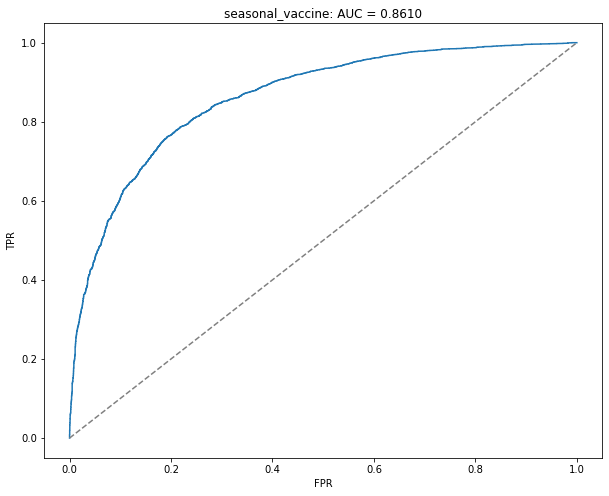

In [ ]:
"""ROC AUC Plot"""

# memunculkan plot ROC ke layar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    predictions_se, 
    'seasonal_vaccine',
    ax=ax
)

In [ ]:
# score ROC AUC untuk prediksi model Seasonal Flu Vaccine
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8610242609729017

## Final ROC AUC Score

In [ ]:
# ROC AUC score untuk gabungan prediksi H1N1 Flu Vaccine dan Seasonal Flu Vaccine
roc_auc_score(y_test, np.hstack((predictions_h1, predictions_se)))

0.8660603670105245

## Final Model

Untuk model final kami mengtrain model dengan dataset train yang penuh (tidak terbagi ke train dan test) untuk menghasilkan model yang lebih robust.

### Seasonal Flu Vaccine

In [ ]:
final_model_se.fit(train, labels.seasonal_vaccine)
final_se = final_model_se.predict_proba(test)
final_se = final_se[:,1].reshape(-1,1)

### H1N1 Flu Vaccine

In [ ]:
final_model.fit(train, labels.h1n1_vaccine)
final_h1 = final_model.predict_proba(test)
final_h1 = final_h1[:,1].reshape(-1,1)

## Make submission

In [ ]:
# load file submission
submission_df = pd.read_csv("./submission_format.csv", 
                            index_col="respondent_id")

In [ ]:
# Mengisi kolom h1n1_vaccine dan seasonal_vaccine dengan hasil prediksi
submission_df["h1n1_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.370448,0.273193
26708,0.079469,0.044629
26709,0.504887,0.735957
26710,0.879725,0.891950
26711,0.687898,0.509354


In [ ]:
"""Submission File"""

# save submission ke file 'submission.csv'
submission_df.to_csv(f'predictions/submission.csv', index=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec225fe7-fd4a-42cd-b6b9-6ef3107ddbf2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>